# Handling Missing Data

1. Mean/ Mode
2. KNN with top 15 features
3. KNN with all the features

In [2]:
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sets import Set

color = sns.color_palette()
%matplotlib inline

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: DeprecationWarning: the sets module is deprecated


Importing Data

In [3]:
df = pd.read_pickle("train_df_partial_filled.pkl")
df.shape

(3064055, 60)

45


C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


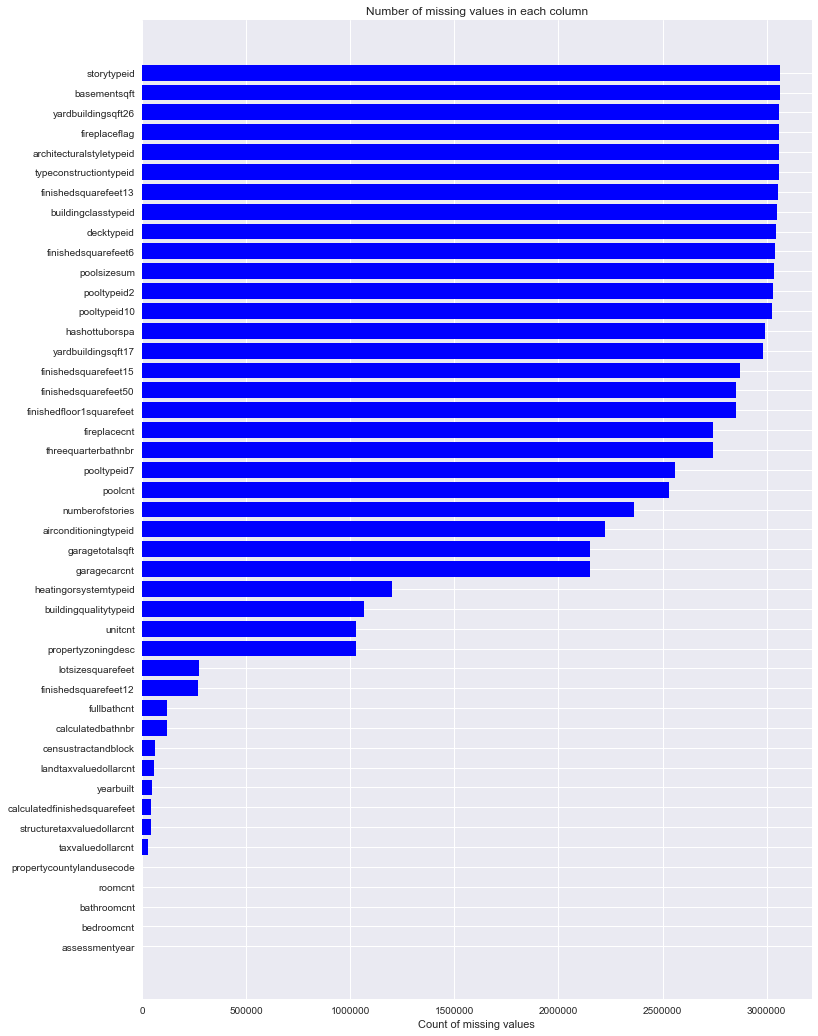

In [11]:
# Missing features
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.ix[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

print missing_df['column_name'].count()

ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

# 1. Mean/ Mode

In [16]:
missing_features = list(missing_df["column_name"].values)

for feature in missing_features:
    try:
        df[feature] = df[feature].fillna(df[feature].mean)
        print ("Successfully filled %s" %feature)
        
    except:
        print("%s not filled" %feature)
        pass

array(['assessmentyear', 'bedroomcnt', 'bathroomcnt', 'roomcnt',
       'propertycountylandusecode', 'taxvaluedollarcnt',
       'structuretaxvaluedollarcnt', 'calculatedfinishedsquarefeet',
       'yearbuilt', 'landtaxvaluedollarcnt', 'censustractandblock',
       'calculatedbathnbr', 'fullbathcnt', 'finishedsquarefeet12',
       'lotsizesquarefeet', 'propertyzoningdesc', 'unitcnt',
       'buildingqualitytypeid', 'heatingorsystemtypeid', 'garagecarcnt',
       'garagetotalsqft', 'airconditioningtypeid', 'numberofstories',
       'poolcnt', 'pooltypeid7', 'threequarterbathnbr', 'fireplacecnt',
       'finishedfloor1squarefeet', 'finishedsquarefeet50',
       'finishedsquarefeet15', 'yardbuildingsqft17', 'hashottuborspa',
       'pooltypeid10', 'pooltypeid2', 'poolsizesum', 'finishedsquarefeet6',
       'decktypeid', 'buildingclasstypeid', 'finishedsquarefeet13',
       'typeconstructiontypeid', 'architecturalstyletypeid',
       'fireplaceflag', 'yardbuildingsqft26', 'basementsqft', '